Kilian Cannet - Noe Boonstra

# Importation

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# Chargement données

In [6]:
#https://www.kaggle.com/priteshshrivastava/sample-github-code
data = pd.read_csv("sample_code.csv", lineterminator='\n',names=['content','lang'])
data.head(10)

,content,lang
0,content,type
1,// Utility.cs\n//\n\nusing System;\nusing Syst...,cs
2,\n{$options.identity.sitename} - Your Accounts...,txt
3,"{\n ""name"": ""opulence/sessions"",\n ""descript...",json
4,package io.mycat.backend.postgresql.packet;\r\...,java
5,TAPi18n._afterUILanguageChange = function() {\...,js
6,"filter:\n paths: [""src/*""]\ntools:\n ext...",yml
7,/**\n * \n */\npackage org.openrtb.dsp.intf.mo...,java
8,"{% extends ""json/page.json"" %}\n{% block title...",json
9,<?php\n\nnamespace JMS\SecurityExtraBundle\Sec...,php


### Filtrage des donnees

In [8]:

#Reduire taille trop grande
#Todo voir si utile
len_cond = [True if 20<=len(s)<=10000 else False for s in data['content']]
data = data[len_cond]

#Filtrer
lang = ['csv', 'txt', 'java', 'cs', 'py', 'cpp','c','js','php']
data = data[data['lang'].isin(lang)]

data_trim= pd.DataFrame(data=data)

'''
for l in lang:
    lang_trim = data[data['lang'] ==l].sample(50000,random_state = 100)
    data_trim = data_trim.append(lang_trim)
'''
#Melager
data_shuffle = data_trim.sample(frac=1)

maxim = data_shuffle.shape[0]
percent = 0.8
part = int(maxim*percent)
train = data_shuffle[0:part]
valid = data_shuffle[part:maxim]

In [9]:
print("taille du training : ",train.shape[0])
print("taille du validation : ",valid.shape[0])

taille du training :  161579
taille du validation :  40395


# Training avec Modeles

#### Comparaison modeles

In [10]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

In [24]:
#[!] Attention ce script prend BEAUCOUP de temps
#Lance un warning mais pas important
import time


names = [
        "SGD Classif",
        "MultiBayes"
        "AdaBoost",
        "RBF SVM",
         "Decision Tree",
        "Random Forest"
]

classifiers = [
    SGDClassifier(loss='hinge', penalty='l2',
                      alpha=1e-3, random_state=42,
                      max_iter=5, tol=None),
    MultinomialNB(),
    AdaBoostClassifier(n_estimators=5),# ok
    SVC(gamma=2, C=1, max_iter=5),#ok
    DecisionTreeClassifier(max_depth=3),#ok
    RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1)#ok
    
]

rows = []
trainScore = []
validScore = []
i =1

t0 = time.time()
for name, clff in zip(names, classifiers):
    print("Training ... (",i,"/",len(classifiers),")")
    clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', clff),
    ])
    clf.fit(train["content"],train["lang"])
    score = clf.score(train["content"], train["lang"])
    
    trainScore.append(clf.score(train["content"],train["lang"]))
    validScore.append(clf.score(valid["content"],valid["lang"]))
    i = i+1


t1 = time.time()
total = t1-t0
print("duration : ",total)
data= [trainScore, validScore]
ptable = pd.DataFrame(data, columns=names)
display(ptable)

Training ... ( 1 / 6 )
Training ... ( 2 / 6 )
Training ... ( 3 / 6 )
Training ... ( 4 / 6 )


C:\Users\kilca\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Training ... ( 5 / 6 )
duration :  276.4530403614044


,SGD Classif,MultiBayesAdaBoost,RBF SVM,Decision Tree,Random Forest
0,0.914395,0.875776,0.694007,0.052556,0.653173
1,0.911326,0.845723,0.693898,0.055477,0.651863


## Modele Multi Bayonesien

### Modele Bayonesien a la Main

In [6]:
# Todo, reprendre le modele bayonesien a la main ([!] multi bayesien peut etre different de bayesien)

### Modele Bayonesien Sklearn

In [7]:
clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB())])

clf = clf.fit(train["content"],train["lang"])

print(clf.score(train["content"],train["lang"]))
print(clf.score(valid["content"],valid["lang"]))


0.8764814734588035
0.846936502042332


#### Verifier Score train/valid

In [30]:
#Prend pas mal de temps

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import numpy as np

from sklearn.model_selection import KFold, cross_val_score

clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB())])

clf = clf.fit(train["content"],train["lang"])

scores = cross_val_score(
    clf, train["content"], train["lang"], cv=5)

print("differents scores cross_validate : ")
print(scores)
print("moyenne des scores :",np.mean(scores))

print("train score :",clf.score(train["content"],train["lang"]))
print("test score : ",clf.score(valid["content"],valid["lang"]))

[0.83905805 0.83744894 0.84060527 0.84066716 0.84217855]
moyenne des scores : 0.8399915965995473
train score : 0.8766361965354409
test score :  0.8476049015967323


In [17]:
#Attention prend beaucoup de temps

cross_v = cross_validate(clf, train["content"], train["lang"], cv=5, return_train_score=True)
print(cross_v)

{'fit_time': array([16.24347949, 15.9299047 , 17.07711411, 15.9575386 , 17.76930308]), 'score_time': array([3.32822394, 3.397686  , 3.62943673, 3.38888597, 3.51273656]), 'test_score': array([0.83905805, 0.83744894, 0.84060527, 0.84066716, 0.84217855]), 'train_score': array([0.87414805, 0.87267818, 0.87366841, 0.8735369 , 0.87366939])}


#### Comparaison avec plot

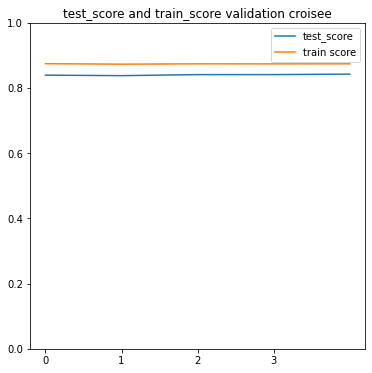

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_ylim([0,1])
plt.xticks(range(0,4))
ax.plot(cross_v['test_score'],label = "test_score")
ax.set_title('test_score and train_score validation croisee');
ax.plot(cross_v['train_score'], label="train score")
ax.legend()

## Modele SGDClassifier

In [9]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                      alpha=1e-3, random_state=42,
                      max_iter=5, tol=None)),
])

clf = clf.fit(train["content"],train["lang"])

print(clf.score(train["content"],train["lang"]))
print(clf.score(valid["content"],valid["lang"]))


0.9141782038507479
0.9129347691545984


# Recherche hyperparametre :

#### Nos Recherches

In [ ]:
#Todo hyperparametre (use_idf, alpha, C ...)
# Todo graphe differents hyperparametre

#### Recherche avec GridSearchCV

In [ ]:
#Todo
#determiner meilleur hyperparam avec GridSearchCV

# Analyse des resultat

In [ ]:
#Todo Matrice de confusion
#Todo accuracy test

In [11]:
y_true =  valid["lang"]
y_pred = clf.predict(valid["content"])
target_names = lang
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         csv       0.92      0.75      0.83      1903
         txt       1.00      0.34      0.50      1299
        java       0.98      0.91      0.94      4610
          cs       1.00      0.12      0.22       319
          py       0.77      1.00      0.87      7815
         cpp       0.98      0.83      0.90      3941
           c       0.88      0.88      0.88      5213

    accuracy                           0.87     25100
   macro avg       0.93      0.69      0.73     25100
weighted avg       0.89      0.87      0.86     25100

